<h1>ROCKS CHALLENGE: Image Classification MobileNet</h1>

<h2>1) Import all dependencies</h2>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

 <h2>2) Import data</h2>

In [7]:
train_dir = './data/train'
val_dir   = './data/val'
test_dir  = './data/test'

In [8]:
#Load Train data
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=4,
    class_mode='binary',
    target_size=(160,160))

#Load Validation data
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    shuffle=False,
    class_mode='sparse',
    target_size=(160,160))

#Load Test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    class_mode='sparse',
    target_size=(160,160))

Found 6813 images belonging to 4 classes.
Found 847 images belonging to 4 classes.
Found 850 images belonging to 4 classes.


<h2>3) Load MobileNet Model</h2>


In [9]:
conv_base = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                            include_top=False,
                                            weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

<h2>4) Set fully connected layer</h2>

In [10]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(4, activation='softmax')(x)
model = Model(conv_base.input, predictions)

<h2>5) Set training parameters</h2>


In [17]:
optimizer = keras.optimizers.RMSprop(learning_rate=1e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./models/mobilenet_.{epoch:02d}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [12]:
tf.debugging.set_log_device_placement(True)
try:
    with tf.device('/device:GPU:0'):
        history = model.fit(
                              train_generator,
                              epochs=20,
                              validation_data=validation_generator,
                              callbacks = callbacks
                             )
except RuntimeError as e:
    print(e)

C:\Users\mat\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
1704/1704 [==============================] - 283s 160ms/step - loss: 0.5096 - accuracy: 0.8039 - val_loss: 0.2834 - val_accuracy: 0.8902
Epoch 2/20
1704/1704 [==============================] - 82s 48ms/step - loss: 0.2533 - accuracy: 0.8996 - val_loss: 0.2424 - val_accuracy: 0.8996
Epoch 3/20
1704/1704 [==============================] - 63s 37ms/step - loss: 0.2343 - accuracy: 0.9036 - val_loss: 0.2348 - val_accuracy: 0.9055
Epoch 4/20
1704/1704 [==============================] - 65s 38ms/step - loss: 0.2307 - accuracy: 0.9068 - val_loss: 0.2303 - val_accuracy: 0.9079
Epoch 5/20
1704/1704 [==============================] - 64s 38ms/step - loss: 0.2279 - accuracy: 0.9112 - val_loss: 0.2278 - val_accuracy: 0.9126
Epoch 6/20
1704/1704 [==============================] - 66s 39ms/step - loss: 0.2239 - accuracy: 0.9134 - val_loss: 0.2303 - val_accuracy: 0.9150
Epoch 7/20
1704/1704 [==============================] - 76s 45ms/step - loss: 0.2224 - accuracy: 0.9149 - val_loss: 0.2272

<h2>7) Show model accuracy history</h2>

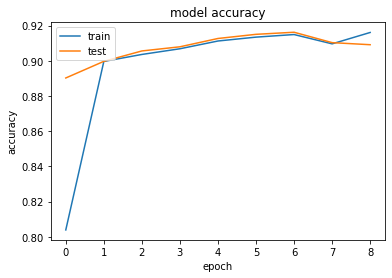

In [13]:
#batch size = 32; learning rate = 1e-5
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2>8) Load saved model</h2>

In [15]:
model = keras.models.load_model('./models/mobilenet_top.h5')

<h2>9) Evaluation of the model on data test</h2>

In [16]:
model.evaluate(test_generator)

27/27 [==============================] - 21s 592ms/step - loss: 0.2160 - accuracy: 0.9141


[0.21599164605140686, 0.9141176342964172]